In [1]:
 %load_ext autoreload

In [2]:
from cbf_opt import asif, cbf, dynamics
import numpy as np
import matplotlib.pyplot as plt

In [3]:
class ACC_Dynamics(dynamics.ControlAffineDynamics):
    def __init__(self, params, **kwargs):
        params['n_dims'] = 3
        params['control_dims'] = 1  # TODO: How to do this correctly?
        super().__init__(params, **kwargs)
        self.mass = params["mass"]
        self.g = params["g"]
        self.f0 = params["f0"]
        self.f1 = params["f1"]
        self.f2 = params["f2"]
        self.rolling_resistance = lambda x: self.f0 + self.f1 * x[1] + self.f2 * x[1] ** 2
        self.v0 = params["v0"]

    def open_loop_dynamics(self, state, time=None):
        return np.array([state[1], -1 / self.mass * self.rolling_resistance(state), self.v0 - state[1]])

    def control_jacobian(self, state, time=None):
        return np.expand_dims(np.array([0, 1 / self.mass, 0]), axis=-1)

In [4]:
class ACC_CBF(cbf.ControlAffineCBF):
    def __init__(self, dynamics, params, **kwargs):
        super().__init__(dynamics, params, **kwargs)
        self.Th = params["Th"]
        self.cd = params["cd"]

    def vf(self, state, time=None):
        return state[2] - self.Th * (state[1] - self.dynamics.v0) ** 2 / (2 * self.cd * self.dynamics.g)

    def vf_dt_partial(self, state, time=None):
        return 0.0
    
    def _grad_vf(self, state, time=None):
        return np.array([0.0, -self.Th * (state[1] - self.dynamics.v0) / (self.cd * self.dynamics.g), 1.0])

In [5]:
params = dict()
params["n_dims"] = 3
params["control_dims"] = 1
params["dt"] = 0.01
params["g"] = 9.81
params['v0'] = 14  # lead vehicle velocity
params['f0'] = 0.1  # friction coefficient
params['f1'] = 5  # friction coefficient
params['f2'] = 0.25  # friction coefficient
params['mass'] = 1650  # vehicle mass

acc = ACC_Dynamics(params)

In [6]:
cbf_params = dict()
cbf_params["cd"] = 0.3
cbf_params["Th"] = 1.8
acc_cbf = ACC_CBF(acc, cbf_params)

In [7]:
vd = 24
umax = cbf_params['cd'] * params['mass'] * params['g']
umin = -umax
alpha = lambda x: 5 * x
nominal_policy = lambda x, t: np.atleast_1d(np.clip(-1000 * (x[1] - vd), umin, umax))
acc_asif = asif.ControlAffineASIF(acc, acc_cbf, alpha=alpha, nominal_policy=nominal_policy)

In [8]:
x0 = np.array([0, 20, 100])
states = [x0]
control = []
control_filt = []
x_filt = x0 
states_filt = [x0]
x = x0
for i in np.arange(0, 10, params['dt']):
    input_nom = nominal_policy(x, i)
    x = acc.step(x, input_nom)
    input_mod = np.atleast_1d(np.clip(acc_asif(x_filt), umin, umax))
    x_filt = acc.step(x_filt, input_mod)
    states.append(x)
    states_filt.append(x_filt)
    control.append(input_nom)
    control_filt.append(input_mod)
states = np.array(states)
states_filt = np.array(states_filt)


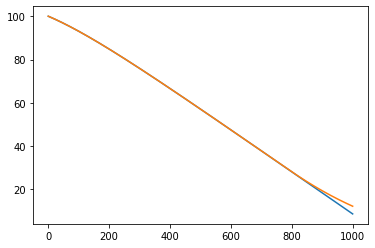

In [9]:
plt.plot(states[:,2])
plt.plot(states_filt[:,2])

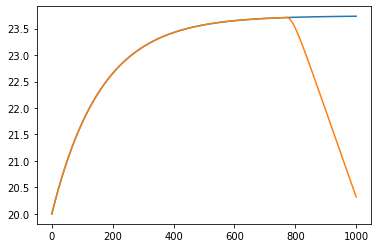

In [10]:
plt.plot(states[:,1])
plt.plot(states_filt[:,1])

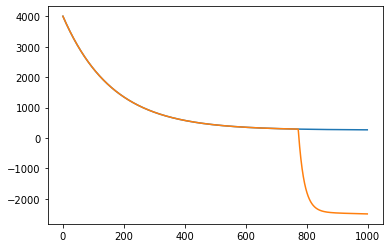

In [11]:
plt.plot(control)
plt.plot(control_filt)